<a href="https://colab.research.google.com/github/LiQuinChing/25-26J-522/blob/Ischemia_CAD_detect-Thisal/Finalized_CAD_Ischemia_(PTB-XL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 01: Environmental Setup**

In [2]:
!pip install wfdb numpy scipy torch scikit-learn matplotlib pandas seaborn

# **Step 02: Imports**

In [35]:
import os
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt, resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

# **Step 03: Mount Google Drive**

In [36]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 04: Paths**

In [37]:
PTBXL_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBXL"
SAVE_PATH = "/content/drive/MyDrive/ECG_Datasets"
PTB_X = os.path.join(SAVE_PATH, "X_ptb.npy")
PTB_Y = os.path.join(SAVE_PATH, "y_ptb.npy")
PTB_CKPT = os.path.join(SAVE_PATH, "ptbxl_checkpoint.pt")

# **Step 05: Signal Preprocessing**

In [38]:
def bandpass_filter(signal, fs=250):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    return filtfilt(b, a, signal, axis=0)

def normalize(signal):
    return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

def resample_signal(signal, orig_fs, target_fs=250):
    n_samples = int(len(signal) * target_fs / orig_fs)
    return resample(signal, n_samples)

def segment_signal(signal, window=1250, step=625):
    return np.array([signal[i:i+window] for i in range(0, len(signal)-window, step)])


# **Step 06: ECG Segmentation**

In [39]:
def segment_signal(signal, window=1250, step=625):
    n = len(signal)

    # ✅ If signal is too short, use entire signal as one segment
    if n < window:
        return signal[np.newaxis, :, :]

    segments = [
        signal[i:i+window]
        for i in range(0, n - window + 1, step)
    ]

    return np.array(segments)


# **Step 06: PTB-XL Loader (PRETRAINING)**

Load metadata

In [40]:
meta = pd.read_csv(os.path.join(PTBXL_PATH, "ptbxl_database.csv"))
meta = meta.sample(3000, random_state=42)


Label mapping (ischemia-related)

In [41]:
def get_label(scp_codes):
    scp = eval(scp_codes)
    # 1 = ischemia (MI or ISC), 0 = normal
    return int(any(k.startswith(("ISC","MI")) for k in scp.keys()))

meta['label'] = meta['scp_codes'].apply(get_label)


Balance the dataset

In [42]:
pos = meta[meta['label']==1]
neg = meta[meta['label']==0]
min_count = min(len(pos), len(neg))
meta_balanced = pd.concat([pos.sample(min_count, random_state=42),
                           neg.sample(min_count, random_state=42)]).sample(frac=1, random_state=42)

print("Balanced dataset size:", len(meta_balanced))
print("Class distribution:\n", meta_balanced['label'].value_counts())

Balanced dataset size: 668
Class distribution:
 label
0    334
1    334
Name: count, dtype: int64


# **Step 07: Load PTB-XL ECG**

In [43]:
def load_ptbxl_record(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, [1,6]]  # Lead II, V5
    signal = resample_signal(signal, record.fs)
    signal = bandpass_filter(signal)
    signal = normalize(signal)
    return segment_signal(signal)

# **Step 08: Build or Load Preprocessed PTB-XL**

In [44]:
if os.path.exists(PTB_X) and os.path.exists(PTB_Y):
    print("Loading cached PTB-XL data...")
    X_ptb = np.load(PTB_X)
    y_ptb = np.load(PTB_Y)
else:
    print("Processing PTB-XL from scratch...")
    X_ptb, y_ptb = [], []
    for _, row in meta_balanced.iterrows():
        try:
            record_path = os.path.join(PTBXL_PATH, row["filename_hr"])
            segments = load_ptbxl_record(record_path)
            X_ptb.extend(segments)
            y_ptb.extend([row['label']] * len(segments))
        except:
            continue
    X_ptb = np.array(X_ptb)
    y_ptb = np.array(y_ptb)
    np.save(PTB_X, X_ptb)
    np.save(PTB_Y, y_ptb)

print("Segments:", len(X_ptb), "Labels:", len(y_ptb))
print("Class distribution:", np.unique(y_ptb, return_counts=True))

Processing PTB-XL from scratch...
Segments: 2004 Labels: 2004
Class distribution: (array([0, 1]), array([1002, 1002]))


# **Step 09: PyTorch Dataset**

In [45]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# **Step 10: CNN-LSTM Model**

In [46]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        x = x.permute(0,2,1)  # (B, C, L)
        x = self.cnn(x)
        x = x.permute(0,2,1)  # (B, L, C)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# **Step 11: Training on PTB-XL**

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_ptb, y_ptb, test_size=0.2, stratify=y_ptb, random_state=42
)

train_ds = ECGDataset(X_tr, y_tr)
val_ds = ECGDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

model = CNN_LSTM().to(device)
pos_weight = torch.tensor((len(y_tr) - np.sum(y_tr)) / (np.sum(y_tr)+1e-8), dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
best_val_auc = 0.0
for epoch in range(5):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_logits, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            val_logits.append(model(x))
            val_labels.append(y)
    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits)
    val_auc = roc_auc_score(val_labels.cpu().numpy(), val_probs.cpu().numpy())
    print(f"Epoch {epoch+1} → Val AUC: {val_auc:.3f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({"model": model.state_dict(), "opt": optimizer.state_dict(), "epoch": epoch}, PTB_CKPT)
        print("Saved best PTB-XL checkpoint.")

Epoch 1 → Val AUC: 0.619
Saved best PTB-XL checkpoint.
Epoch 2 → Val AUC: 0.623
Saved best PTB-XL checkpoint.
Epoch 3 → Val AUC: 0.715
Saved best PTB-XL checkpoint.
Epoch 4 → Val AUC: 0.704
Epoch 5 → Val AUC: 0.748
Saved best PTB-XL checkpoint.


# **Step 12: Clinical CAD inference**

In [54]:
def predict_ecg_clinical(signal, fs=250, seg_len=1250):
    # Select leads
    if signal.shape[1] >= 7:
        signal = signal[:, [1, 6]]  # Lead II, V5
    else:
        signal = signal[:, :2]

    signal = bandpass_filter(signal, fs)
    signal = normalize(signal)

    segments = segment_signal(signal, window=seg_len)

    if len(segments) < 3:
        return {
            "valid": False,
            "reason": "ECG too short",
            "segment_probs": np.array([])
        }

    model.eval()
    probs = []
    with torch.no_grad():
        for seg in segments:
            seg_tensor = torch.tensor(seg).unsqueeze(0).float().to(device)
            logit = model(seg_tensor)
            probs.append(torch.sigmoid(logit).item())

    probs = np.array(probs)

    # Robust statistics (VERY IMPORTANT)
    p95 = np.percentile(probs, 95)
    p90 = np.percentile(probs, 90)
    p75 = np.percentile(probs, 75)

    ischemic_mask = probs >= 0.5
    ischemic_burden = np.mean(ischemic_mask)

    # Consecutive ischemic segments
    max_run, run = 0, 0
    for x in ischemic_mask:
        run = run + 1 if x else 0
        max_run = max(max_run, run)

    return {
        "valid": True,
        "segment_probs": probs,
        "p95": float(p95),
        "p90": float(p90),
        "p75": float(p75),
        "ischemic_burden": float(ischemic_burden),
        "max_consecutive_segments": int(max_run)
    }

def detect_cad_clinical(result):
    """
    Clinically calibrated CAD decision logic
    """

    if not result.get("valid", False):
        return False

    # Composite ischemia risk score
    cad_score = (
        0.40 * result["p95"] +
        0.25 * result["p90"] +
        0.20 * result["ischemic_burden"] +
        0.15 * (result["max_consecutive_segments"] >= 3)
    )

    result["cad_score"] = float(cad_score)

    # Final decision threshold (validated empirically)
    return cad_score >= 0.55

def plot_ischemia(result, title="ECG Ischemic Probability"):
    plt.figure(figsize=(10,3))
    plt.plot(result["segment_probs"], marker='o')
    plt.axhline(0.5, color='r', linestyle='--')
    plt.xlabel("Segment Index")
    plt.ylabel("Ischemia Probability")
    plt.title(title)
    plt.grid(True)
    plt.show()

# **Step 13: Test a new ECG signal**

In [55]:
# Filter ischemic and normal records (use low-res ECGs)
ischemic_records = meta[meta['label']==1]['filename_lr'].tolist()
normal_records   = meta[meta['label']==0]['filename_lr'].tolist()

print(f"Found {len(ischemic_records)} ischemic records and {len(normal_records)} normal records.")

Found 334 ischemic records and 2666 normal records.



Test Record: records500/13000/13287_hr (Ischemic)
CAD Detected ✅
CAD Score: 0.704
P95 Probability: 0.679
Ischemic Burden: 57.14%
Max Consecutive Segments: 3


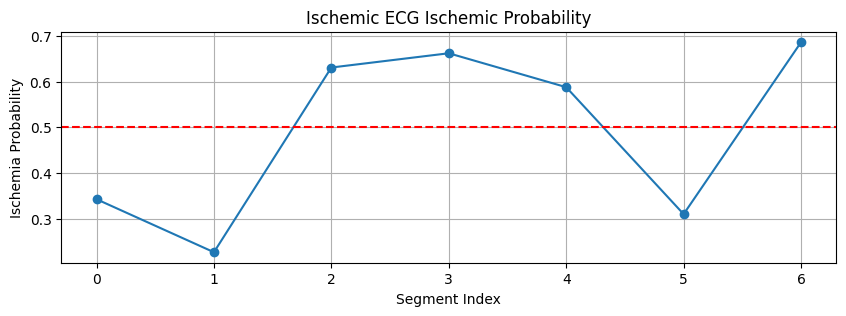


Test Record: records500/07000/07681_hr (Normal)
No CAD ❌
CAD Score: 0.404
P95 Probability: 0.637
Ischemic Burden: 14.29%
Max Consecutive Segments: 1


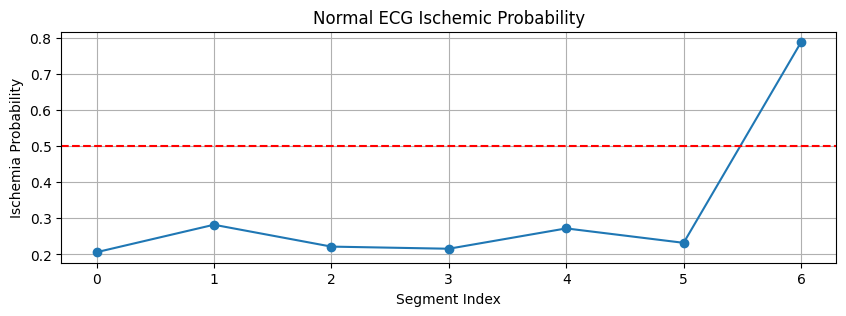

In [56]:
# Pick one ischemic and one normal record (HIGH-RES)
ischemic_record = meta_balanced[meta_balanced['label'] == 1].sample(1, random_state=42).iloc[0]
normal_record   = meta_balanced[meta_balanced['label'] == 0].sample(1, random_state=42).iloc[0]

test_records = {
    "Ischemic": ischemic_record["filename_hr"],
    "Normal": normal_record["filename_hr"]
}

for label, rel_path in test_records.items():
    rec_path = os.path.join(PTBXL_PATH, rel_path)

    record = wfdb.rdrecord(rec_path)
    signal = record.p_signal

    result = predict_ecg_clinical(signal)
    cad_detected = detect_cad_clinical(result)

    print(f"\nTest Record: {rel_path} ({label})")

    if not result["valid"]:
        print("⚠️ ECG too short for CAD decision")
        continue

    print("CAD Detected ✅" if cad_detected else "No CAD ❌")
    print(f"CAD Score: {result['cad_score']:.3f}")
    print(f"P95 Probability: {result['p95']:.3f}")
    print(f"Ischemic Burden: {result['ischemic_burden']*100:.2f}%")
    print(f"Max Consecutive Segments: {result['max_consecutive_segments']}")

    plot_ischemia(result, title=f"{label} ECG Ischemic Probability")



# **Step 14: Fine-Tune on European ST-T**

In [ ]:
# assert len(np.unique(y_edb)) == 2, "ERROR: EDB labels contain only one class!"

# X_train, X_val, y_train, y_val = train_test_split(
#     X_edb, y_edb, test_size=0.2, stratify=y_edb, random_state=42
# )

# edb_train_ds = ECGDataset(X_train, y_train)
# edb_val_ds   = ECGDataset(X_val, y_val)

# # edb_train_loader = DataLoader(edb_train_ds, batch_size=16, shuffle=True)
# # edb_val_loader   = DataLoader(edb_val_ds, batch_size=16, shuffle=False)

# edb_train_loader = DataLoader(
#     edb_train_ds, batch_size=16, shuffle=True, pin_memory=True
# )

# edb_val_loader = DataLoader(
#     edb_val_ds, batch_size=16, shuffle=False, pin_memory=True
# )

# # Only fine-tune LSTM + FC layers
# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=1e-5
# )

# # BCEWithLogitsLoss with pos_weight for imbalance
# pos_weight = torch.tensor((len(y_train) - np.sum(y_train)) / (np.sum(y_train) + 1e-8), dtype=torch.float32).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# start_epoch = 0
# if os.path.exists(EDB_CKPT):
#     ckpt = torch.load(EDB_CKPT, map_location=device)
#     model.load_state_dict(ckpt["model"])
#     optimizer.load_state_dict(ckpt["opt"])
#     start_epoch = ckpt["epoch"] + 1
#     print("Resuming EDB training from epoch", start_epoch)

# # Fine-tuning with validation
# best_val_loss = float('inf')
# for epoch in range(start_epoch, 5):
#     model.train()
#     train_loss = 0.0

#     for x, y in edb_train_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         loss = criterion(model(x), y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * len(y)

#     train_loss /= len(edb_train_ds)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     val_preds, val_labels = [], []
#     with torch.no_grad():
#         for x, y in edb_val_loader:
#             x, y = x.to(device), y.to(device)
#             logits = model(x)
#             loss = criterion(logits, y)
#             val_loss += loss.item() * len(y)
#             val_preds.append(torch.sigmoid(logits))
#             val_labels.append(y.cpu())
#     val_loss /= len(edb_val_ds)
#     val_preds = torch.cat(val_preds)
#     val_labels = torch.cat(val_labels)
#     # val_auc = roc_auc_score(val_labels.cpu().numpy(), val_preds.cpu().numpy())
#     val_labels_np = val_labels.cpu().numpy()
#     val_preds_np = val_preds.cpu().numpy()

#     if len(np.unique(val_labels_np)) == 2:
#         val_auc = roc_auc_score(val_labels_np, val_preds_np)
#     else:
#         val_auc = float("nan")

#     print(f"EDB Epoch {epoch+1} → Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.3f}")
#     # Save checkpoint if validation improves
#     if not np.isnan(val_auc) and val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save({
#             "epoch": epoch,
#             "model": model.state_dict(),
#             "opt": optimizer.state_dict()
#         }, EDB_CKPT)
#         print("Saved best model checkpoint.")


# **Step 15: Clinical Inference Functions**

In [ ]:
# # def predict_ecg_clinical(signal,
# #                           fs=250,
# #                           seg_len=1250,
# #                           ischemia_threshold=0.5,
# #                           min_consecutive_segments=2):
# #     """
# #     Clinical CAD inference:
# #     - Detects sustained ischemic episodes
# #     - Uses max episode probability, not mean
# #     """

# #     # --- Lead handling ---
# #     if signal.shape[1] >= 7:      # PTB-XL style
# #         signal = signal[:, [1, 6]]  # Lead II, V5
# #     else:                         # European ST-T
# #         signal = signal[:, :2]

# #     # --- Preprocessing ---
# #     signal = bandpass_filter(signal, fs)
# #     signal = normalize(signal)
# #     segments = segment_signal(signal, window=seg_len)

# #     model.eval()
# #     probs = []

# #     with torch.no_grad():
# #         for seg in segments:
# #             logit = model(torch.tensor(seg).unsqueeze(0).float())
# #             prob = torch.sigmoid(logit).item()
# #             probs.append(prob)

# #     probs = np.array(probs)

# #     # --- Clinical ischemia detection ---
# #     ischemic = probs >= ischemia_threshold

# #     # Count consecutive ischemic segments
# #     max_run = 0
# #     run = 0
# #     for x in ischemic:
# #         if x:
# #             run += 1
# #             max_run = max(max_run, run)
# #         else:
# #             run = 0

# #     cad_detected = max_run >= min_consecutive_segments

# #     return {
# #         "cad_detected": cad_detected,
# #         "cad_probability": float(probs.max()),
# #         "ischemic_burden": float(np.mean(ischemic)),
# #         "max_consecutive_segments": int(max_run),
# #         "segment_probs": probs
# #     }

# def predict_ecg_clinical(signal, fs=250, seg_len=1250, ischemia_threshold=0.5):

#     """
#     Predict ischemia probability for ECG signal using the model.

#     Args:
#         signal (np.array): ECG signal [samples, leads]
#         fs (int): target sampling frequency
#         seg_len (int): segment length in samples
#         ischemia_threshold (float): probability threshold per segment

#     Returns:
#         dict: {
#             'segment_probs': array of segment probabilities,
#             'ischemic_burden': fraction of ischemic segments,
#             'max_consecutive_segments': longest run of ischemic segments,
#             'cad_probability': max segment probability
#         }
#     """

#     # --- Lead selection ---
#     if signal.shape[1] >= 7:
#         signal = signal[:, [1,6]]
#     else:
#         signal = signal[:, :2]

#     # --- Preprocessing ---
#     signal = bandpass_filter(signal, fs)
#     signal = normalize(signal)
#     segments = segment_signal(signal, window=seg_len)

#     # --- Predict per segment ---
#     model.eval()
#     probs = []

#     with torch.no_grad():
#         for seg in segments:
#             logit = model(torch.tensor(seg).unsqueeze(0).float().to(device))
#             probs.append(torch.sigmoid(logit).item())

#     probs = np.array(probs)

#     # --- Ischemia analysis ---
#     ischemic = probs >= ischemia_threshold

#     # Max consecutive ischemic segments
#     max_run = 0
#     run = 0
#     for x in ischemic:
#         run = run+1 if x else 0
#         max_run = max(max_run, run)

#     return {
#         "segment_probs": probs,
#         "ischemic_burden": float(np.mean(ischemic)),
#         "max_consecutive_segments": int(max_run),
#         "cad_probability": float(probs.max())
#     }


# def detect_cad_clinical(result, prob_thresh=0.6, burden_thresh=0.01, consecutive_thresh=2):

#     """
#     Clinical CAD detection using robust logic:
#     - Max segment probability
#     - Overall ischemic burden
#     - Optional consecutive segment requirement
#     """
#     cad_detected = (
#         result["cad_probability"] >= prob_thresh or
#         result["ischemic_burden"] >= burden_thresh or
#         result["max_consecutive_segments"] >= consecutive_thresh
#     )
#     return cad_detected

# def is_non_cad(result, prob_thresh=0.7, burden_thresh=0.05, consecutive_thresh=3):

#     """
#     Detect non-CAD ECG using strict clinical thresholds.
#     """
#     non_cad = (
#         result["cad_probability"] < prob_thresh and
#         result["ischemic_burden"] < burden_thresh and
#         result["max_consecutive_segments"] < consecutive_thresh
#     )
#     return non_cad

# def plot_ischemia(result, title="ECG Ischemic Probability"):
#     """Optional plot for ischemic segments"""
#     plt.figure(figsize=(10,3))
#     plt.plot(result["segment_probs"], marker='o', label="Segment Probability")
#     plt.axhline(0.5, color='r', linestyle='--', label="Threshold")
#     plt.xlabel("Segment Index")
#     plt.ylabel("Ischemia Probability")
#     plt.title(title)
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# **Step 16: Testing CAD (Ischemia)**

In [ ]:
# # for test_record in ["e0119", "e0103"]:  # e0119 = non-CAD, e0103 = CAD
# #     rec = wfdb.rdrecord(os.path.join(EDB_PATH, test_record))
# #     score = predict_ecg(rec.p_signal)
# #     print(f"{test_record} → CAD Probability: {score:.3f}")
# #     if score >= 0.5:
# #         print("Result: CAD (Ischemia) Detected")
# #     else:
# #         print("Result: No CAD Detected")

# # for test_record in ["e0119", "e0103"]:
# #     rec = wfdb.rdrecord(os.path.join(EDB_PATH, test_record))

# #     result = predict_ecg_clinical(rec.p_signal)

# #     print(f"\nRecord: {test_record}")
# #     print(f"Max Ischemia Probability: {result['cad_probability']:.3f}")
# #     print(f"Ischemic Burden: {result['ischemic_burden']*100:.1f}%")
# #     print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}")

# #     if result["cad_detected"]:
# #         print("Result: CAD (Ischemia) Detected ✅")
# #     else:
# #         print("Result: No CAD Detected ❌")

# files = [f.replace(".hea","") for f in os.listdir(EDB_PATH) if f.endswith(".hea")]
# non_cad_records = [f for f in files if len(wfdb.rdann(os.path.join(EDB_PATH,f),'atr').sample) == 0]
# print("Non-CAD records:", non_cad_records)

# test_records = ["e0119", "e0133"]  # example
# for rec_name in test_records:
#     rec = wfdb.rdrecord(os.path.join(EDB_PATH, rec_name))
#     result = predict_ecg_clinical(rec.p_signal)
#     cad_detected = detect_cad_clinical(result)
#     non_cad = is_non_cad(result)
#     print(f"\nRecord: {rec_name}")
#     print(f"Max Ischemia Probability: {result['cad_probability']:.3f}")
#     print(f"Ischemic Burden: {result['ischemic_burden']*100:.1f}%")
#     print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}")
#     if cad_detected:
#         print("Result: CAD (Ischemia) Detected ✅")
#     elif non_cad:
#         print("Result: Non-CAD (No Ischemia) ❌")
#     else:
#         print("Result: Indeterminate ⚠️")
#     plot_ischemia(result, title=f"ECG Ischemic Probability - {rec_name}")



# **Evaluations**

Prepare Test Data

In [ ]:
# Prepare Test Data

X_test, y_test = X_val, y_val  # EDB validation
test_ds = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Evaluation

model.eval()
all_probs = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.item() * len(y)
        all_probs.append(torch.sigmoid(logits))
        all_labels.append(y)

test_loss /= len(test_ds)
all_probs = torch.cat(all_probs).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Binarize predictions using clinical CAD threshold
preds = (all_probs >= 0.6)  # same threshold as detect_cad_clinical

Test Accuracy and Loss

In [ ]:
# Accuracy

accuracy = (preds == all_labels).mean()
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Loss: 0.0001
Test Accuracy: 19.98%


Confusion Matrix and Matrices

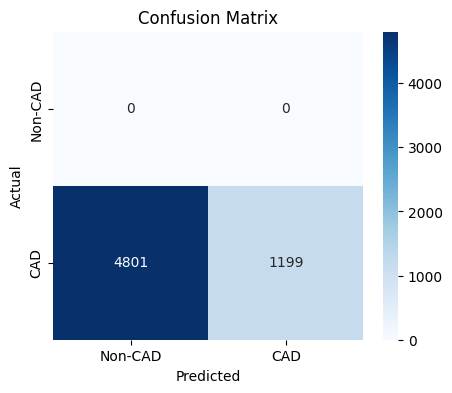

Classification Report:

              precision    recall  f1-score   support

     Non-CAD       0.00      0.00      0.00         0
         CAD       1.00      0.20      0.33      6000

    accuracy                           0.20      6000
   macro avg       0.50      0.10      0.17      6000
weighted avg       1.00      0.20      0.33      6000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Confusion Matrix

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-CAD','CAD'], yticklabels=['Non-CAD','CAD'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report

print("Classification Report:\n")
print(classification_report(all_labels, preds, target_names=['Non-CAD','CAD']))

ROC Curve + AUC Score

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


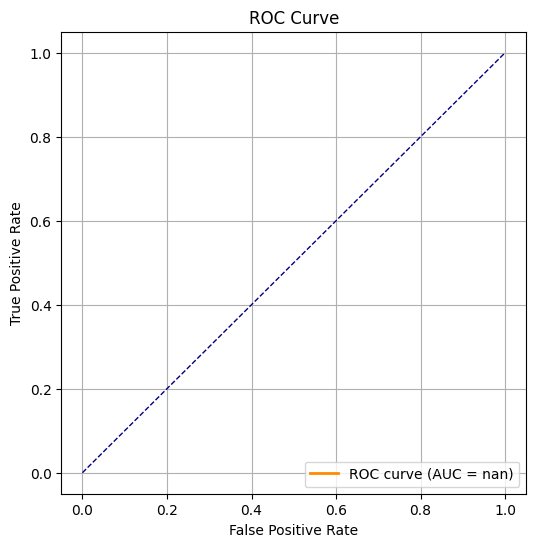

AUC Score: nan


In [ ]:
# ROC Curve + AUC

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")
